In [1]:
Folder='./'
DataNameBasis='/'
verbose=False

# Load the data

In [2]:
import glob
import scipy.ndimage as ndimage
import numpy as np


File=glob.glob(Folder+DataNameBasis+"*.img")

########################
#Load and parse the file
########################
file=open(File[0],mode='rb')
data_raw=file.read()
IndexDataStart=np.frombuffer(data_raw[2:4], dtype=np.dtype('u2'))[0]+64

if verbose==True:
    print(data_raw[64:IndexDataStart].decode())

########################
#Recover image basic parameter
########################
BitDepth=np.frombuffer(data_raw[12:13], dtype=np.dtype('u1'))
BytesPerPixel=int(data_raw[data_raw.find(b'BytesPerPixel')+14: \
                                      data_raw.find(b'BytesPerPixel')+15].decode())

#It can't be that there is more than 2048 pixel which should then show as as 4 char
#so we split to only slect the right amount of character
ImgWidth=int(data_raw[data_raw.find(b'HWidth')+8: \
                                      data_raw.find(b'HWidth')+13].decode().split('"')[0])
ImgHeight=int(data_raw[data_raw.find(b'VWidth')+8: \
                                      data_raw.find(b'VWidth')+13].decode().split('"')[0])

IndexDataEnd=ImgWidth*ImgHeight*BytesPerPixel+IndexDataStart

########################
#Recover the unit for the different axis
########################

TimeUnit=data_raw[data_raw.find(b'ScalingYUnit'): \
                                      data_raw.find(b'ScalingYUnit')+18].decode().split('"')
XUnit=data_raw[data_raw.find(b'ScalingXUnit'): \
                                      data_raw.find(b'ScalingXUnit')+18].decode().split('"')

if TimeUnit[1]=='' :
    Time=np.linspace(-1,1,ImgHeight)
    TimeUnit[1]='a.u'
if XUnit[1]=='':
    x=np.linspace(-1,1,ImgWidth)
    XUnit[1]='a.u'
elif TimeUnit[1]=='a.u'  and XUnit[1]!='':
    print('a')
    x=np.frombuffer(data_raw[IndexDataEnd:], dtype=np.dtype('<f4'))
elif TimeUnit[1]!='' and XUnit[1]!='':
    temp=np.frombuffer(data_raw[IndexDataEnd:], dtype=np.dtype('<f4'))
    x=temp[0:ImgWidth]
    Time=temp[ImgWidth:]

Data_kin=np.zeros([len(File),ImgHeight,ImgWidth])
Data_gif=np.zeros([len(File),ImgHeight,ImgWidth])
TimeExp=np.zeros([len(File),1])
images = []

for i,File_temp in enumerate(File):
    file=open(File_temp,mode='rb')
    data_raw_kin=file.read()
    IndexDataStart=np.frombuffer(data_raw_kin[2:4], dtype=np.dtype('u2'))[0]+64
    IndexDataEnd=ImgWidth*ImgHeight*BytesPerPixel+IndexDataStart
    
    TimeTemp=data_raw_kin[data_raw_kin.find(b'Time'): \
                                      data_raw_kin.find(b'Time')+16].decode().split('"')
    #print(TimeTemp)
    try:
        TimeExp[i]=int(TimeTemp[1].split(':')[0])*3600+int(TimeTemp[1].split(':')[1])*60+int(TimeTemp[1].split(':')[2])
    except:
        if i==1:
            TimeExp[0]=0
        TimeExp[i]=float(TimeTemp[1].split('ms')[0])
    if BytesPerPixel==4:
        temp=np.reshape(np.frombuffer(data_raw_kin[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u4')), newshape=(ImgHeight, ImgWidth))
    elif BytesPerPixel==2:
        temp=np.reshape(np.frombuffer(data_raw_kin[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u2')), newshape=(ImgHeight, ImgWidth))
    Data_kin[i,:,:]=temp
TimeExp=np.round(TimeExp-TimeExp[0],0)


# Data fitting (first spectra)

## Function to minimize
The way scipy.differential_evolution works is by minimizing a given function  

In [3]:
ScalingParameterG=[1,100,10]
def Gaussian(x,a,b,c):
	return np.array(a*ScalingParameterG[0] * np.exp(-0.5*np.power((x-b*ScalingParameterG[1])/(c*ScalingParameterG[2]),2)),dtype='float32')

def MultiExponentialFunction(para,data):
	taui, fi = np.split(para, 2)
	x=data[0]
	y=data[1]
	return np.sum((y - np.dot(fi, np.exp(-np.outer(1./taui, x))))**2)

def MultiExponentialFunctionRsq(para,data):
	taui, fi = np.split(para, 2)
	x=data[0]
	y=data[1]
	return 1-np.sum((y - np.dot(fi, np.exp(-np.outer(1./taui, x))))**2)/np.sum((y-np.mean(y))**2)

In [6]:
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

Time_interp=np.linspace(0,(np.max(Time)-np.min(Time))*0.8,num=1000)

# Multi exponential fitting
DegreeExponential=3
Data_fit_s=np.empty([len(File)-1,Time_interp.shape[0]])
Data_exp_s=np.empty([len(File)-1,Time_interp.shape[0]])
Rsq_Overfit=np.empty(len(File)-1)

#Gaussian fitting
WavePeak=np.empty(len(File))
Max_int_Theoritical=np.empty(len(File))
Max_int=np.empty(len(File))
Rsq_kin=np.empty(len(File))

#Random figure things

#fig=plt.figure()
#ax1=plt.subplot(1,1,1)


for i,File_temp in enumerate(File):

    Time_max_index=np.unravel_index(Data_kin[i,:,:].argmax(), Data_kin[i,:,:].shape)[0]
    #First we try to fit to a gaussian to find rougly the center of the peak 
    data_fit_Gaussian=np.squeeze(np.mean(Data_kin[i,Time_max_index-5:Time_max_index+5,:],0))
    if i==0:
        IntNormaGaussian=np.max(data_fit_Gaussian)
    data_fit_Gaussian=data_fit_Gaussian/IntNormaGaussian

    try:
    	########################
    	#Gaussian fit
    	########################

        popt, pcov = curve_fit(Gaussian,x,data_fit_Gaussian,p0=[1,7.30,5.0])
        curvey = Gaussian(x,popt[0],popt[1],popt[2])


        Max_int_Theoritical[i]=np.max(curvey)*IntNormaGaussian*ScalingParameterG[0]
        Max_int[i]=np.max(data_fit_Gaussian)*IntNormaGaussian
        WavePeak[i]=popt[1]*ScalingParameterG[1]
    except Exception as e:
        print(e)
  

    # We now take a slice in time at the theoritical maximum and try to fit a multiexponential
    temp=np.squeeze(Data_kin[i,:,np.abs(x-WavePeak[i]).argmin()-5:np.abs(x-WavePeak[i]).argmin()+5])
    data_temp_kin=np.squeeze((np.mean(temp,1)))

    index_max_time=data_temp_kin.tolist().index(max(data_temp_kin))

    Time_fit=Time[index_max_time:]-np.min(Time[index_max_time])
    Data_fit=(data_temp_kin[index_max_time:]-np.min(data_temp_kin))/np.max(data_temp_kin[index_max_time:]-np.min(data_temp_kin))

    bounds = [[min(Time_fit), max(Time_fit)]]*DegreeExponential + [[min(Data_fit), max(Data_fit)]]*DegreeExponential
    
    result = differential_evolution(func=MultiExponentialFunction,bounds=bounds,args=((Time_fit,Data_fit),))
    s = result['x']
    tau_fit,Coeff_fit=np.split(s,2)
    Rsq_Overfit[i] = MultiExponentialFunctionRsq(s,(Time_fit,Data_fit))
    Data_fit_s[i,:]=np.interp(Time_interp,Time_fit,np.dot(Coeff_fit, np.exp(-np.outer(1./tau_fit, Time_fit))))
    Data_exp_s[i,:]=np.interp(Time_interp,Time_fit,Data_fit)

IndexError: index 0 is out of bounds for axis 0 with size 0

## Tools to check the fitting

IndexError: index 0 is out of bounds for axis 0 with size 0

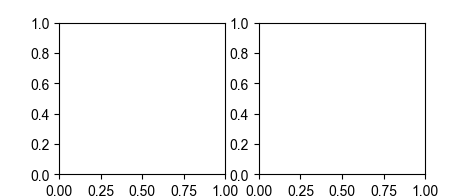

In [5]:
%matplotlib widget
import matplotlib as mat
from matplotlib.widgets import Button, Slider

cms=1/2.54

fig1=plt.figure(figsize=(12*cms,5*cms))
ax1 =plt.subplot(1,2,1)
ax2 =plt.subplot(1,2,2)

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})

line,=ax1.plot(Time_interp,Data_fit_s[0,:])
line2,=ax1.plot(Time_interp,Data_exp_s[0,:])
ax2.scatter(np.linspace(0,len(File[:-1]),num=len(File[:-1]),dtype='int'),Rsq_Overfit,s=1)
ax2.plot(ax2.get_xlim(),[0.95,0.95],color='r')

ax1.set_ylim([0,1.2*np.max(Data_exp_s)])

def update(k):
    line.set_ydata(Data_fit_s[int(np.floor(k)),:])
    line2.set_ydata(Data_exp_s[int(np.floor(k)),:])
    
    fig1.canvas.draw_idle()

fig1.subplots_adjust(left=0.25, bottom=0.25)
axFile = fig1.add_axes([0.25, 0.1, 0.65, 0.03])

file_slider = Slider(
    ax=axFile,
    label="File",
    valmin=0,
    valmax=len(File)-2,
    valinit=0,
    valfmt='%0.0f'
)

file_slider.on_changed(update)


# Differential data analysis

C:\Users\gautier\AppData\Local\Temp\ipykernel_5556\413600004.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ycolor=cm.get_cmap('coolwarm',len(File[0:-1]))


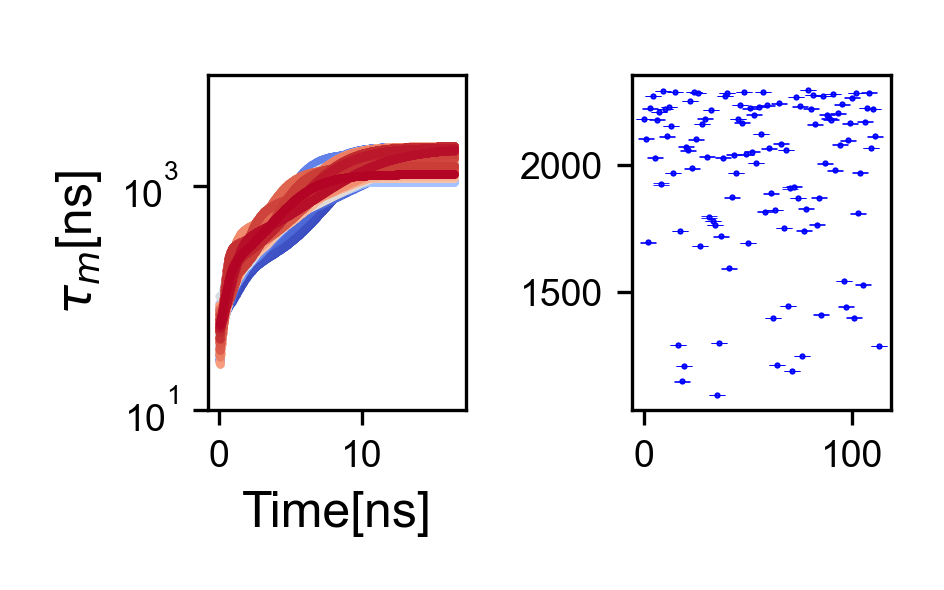

In [ ]:
from matplotlib import cm

cms=1/2.54
tau=np.empty([len(File)-1,Time_interp.shape[0]])
End_stab=5

for i,File_temp in enumerate(File[0:-1]):
    tau[i,:]=-1/(0.5*np.gradient(np.log(Data_fit_s[i,:])))


fig1=plt.figure(figsize=(8*cms,5*cms))
ax1 =plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

tm=np.zeros(np.shape(tau)[0])
tm_err=np.zeros(np.shape(tau)[0])

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})
ycolor=cm.get_cmap('coolwarm',len(File[0:-1]))

for i,File_temp in enumerate(File[0:-1]):
    temp=ax1.scatter(Time_interp,tau[i,:],color=ycolor(i/len(File[0:-1])),s=1)
    tm[i]=np.mean(tau[i,-End_stab:])
    tm_err[i]=np.std(tau[i,-End_stab:])

ax1.set_ylabel('$\\tau_m$[{}]'.format(TimeUnit[1]))
ax1.set_xlabel('Time[{}]'.format(TimeUnit[1]))
ax1.set_yscale('log')
ax1.set_ylim([1E1,1E4])

ax2.errorbar(np.linspace(0,len(File[:-1]),num=len(File[:-1]),dtype='int'),tm,yerr=tm_err,capsize=2,fmt='.',color='blue',elinewidth=0.2,capthick=0.2,markersize=1)
#ax2.set_yscale('log')
#ax2.set_ylim([1E3,3E3])
plt.tight_layout()
plt.savefig("MultiExponentialn=3Fit.png")
    

## Plot specific tm

C:\Users\gautier\AppData\Local\Temp\ipykernel_5556\3153979383.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ycolor=cm.get_cmap('coolwarm',2)


(10.0, 10000.0)

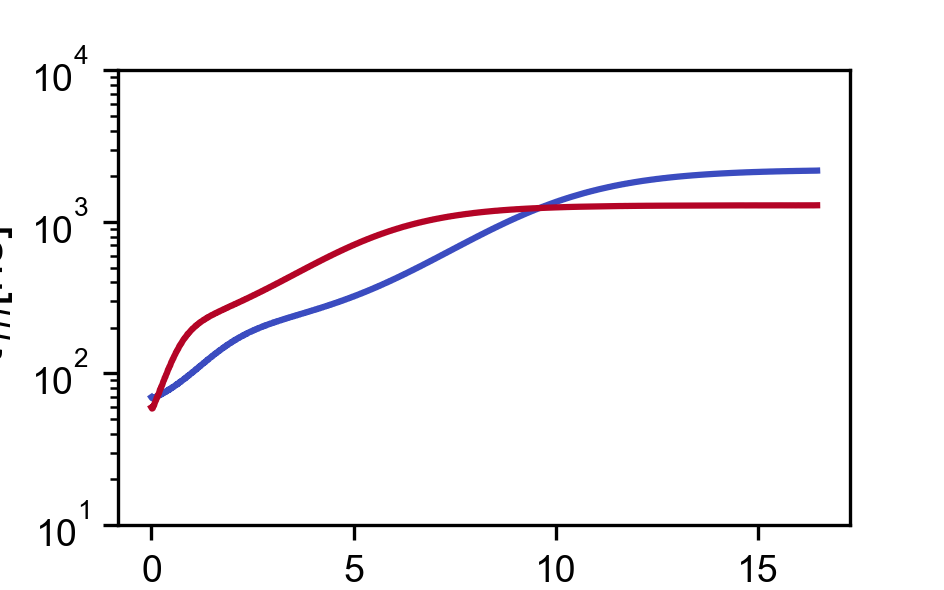

In [ ]:
fig1=plt.figure(figsize=(8*cms,5*cms))
ax1 =plt.subplot(1,1,1)

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})
ycolor=cm.get_cmap('coolwarm',2)

ax1.plot(Time_interp,tau[0,:],color=ycolor(0))
ax1.plot(Time_interp,tau[-1,:],color=ycolor(1))
ax1.set_ylabel('$\\tau_m$[{}]'.format(TimeUnit[1]))
ax1.set_xlabel('Time[{}]'.format(TimeUnit[1]))
ax1.set_yscale('log')
ax1.set_ylim([1E1,1E4])